In [ ]:
%reload_ext autoreload
%autoreload 2
#import os
#os.environ["MKL_NUM_THREADS"] = "1"
#os.environ["NUMEXPR_NUM_THREADS"] = "1"
#os.environ["OMP_NUM_THREADS"] = "1"

from pathlib import Path
home = str(Path.home())
import sys
import numpy as np
import matplotlib.pyplot as plt
import bct
import sys
sys.path.append(home + '/workspace/networkqit')
import networkqit as nq
from networkqit.graphtheory.models.MEModels import CWTECM, UBCM, UWCM, UECM3
from networkqit.utils.visualization import plot_mle
import pandas as pd
import pickle
import matplotlib as mpl
plt.style.use('default')
# Here we set Helvetica as the default font
mpl.rcParams.update({
    'font.family':'sans-serif',
    'font.sans-serif':['Helvetica'],
    'svg.fonttype':'none'
    })
# disable tex interpretation of text
mpl.rc('text', usetex=False)

Loglikelihood =  -1338.2923897648466


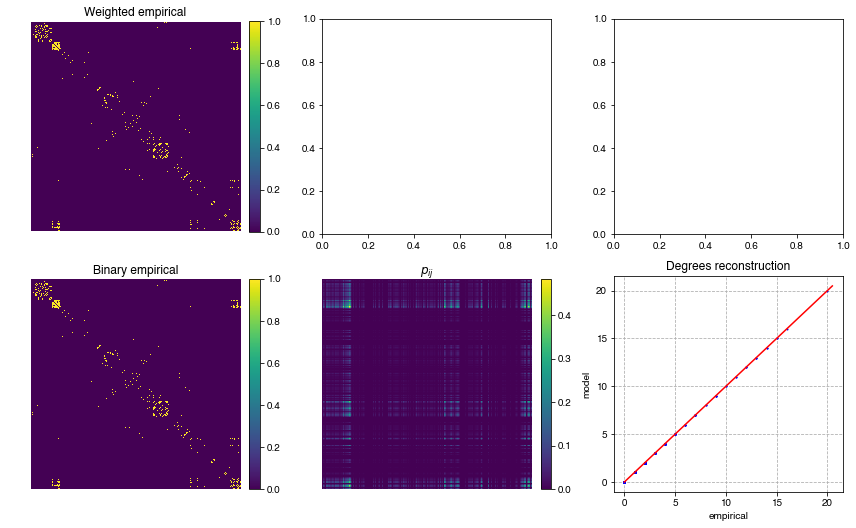

In [7]:
filename = home + '//workspace/communityalg/data/GroupAverage_rsfMRI_unthr.adj'
G = np.round(np.loadtxt(filename)[0:256,0:256]*100)
t = 100
G = bct.threshold_absolute(G,t)
G = bct.binarize(G)
tstar = G[np.nonzero(G)].min()
A = (G>0).astype(float)
k = A.sum(axis=0)
m = k.sum()
s = G.sum(axis=0)
Wtot = s.sum()
n = len(G)
pairs = n*(n-1)/2
M = nq.UBCM(N=len(G))
sol = M.fit(G=G, method='MLE', ftol=1E-9, verbose=0)
print('Loglikelihood = ', M.loglikelihood(G,sol['x']))
nq.plot_mle(G, M.expected_adjacency(sol['x']) )#, M.expected_weighted_adjacency(sol['x']))
plt.show()

In [8]:
batch_size=4
beta_range=np.logspace(-4,3,150)
Ws = M.sample_adjacency(theta=sol['x'],batch_size=batch_size)
S = nq.entropy(nq.graph_laplacian(G),beta_range=beta_range)
Srandom = nq.entropy(nq.graph_laplacian(M.expected_adjacency(theta=sol['x'])),beta_range=beta_range)
Srandombatch = nq.entropy(nq.graph_laplacian(Ws),beta_range=beta_range)

dklnull = nq.relative_entropy(nq.graph_laplacian(G),nq.graph_laplacian(M.expected_adjacency(theta=sol['x'])),beta_range)
dklsamples = nq.relative_entropy(nq.graph_laplacian(G),nq.graph_laplacian(Ws),beta_range)

dklsamplessamples=[]
for i in range(batch_size):
    dklsamplessamples.append(nq.relative_entropy(nq.graph_laplacian(Ws)[i,...],nq.graph_laplacian(Ws),beta_range)) # it does the average over Ws
dklsamplessamples=np.asarray(dklsamplessamples).T

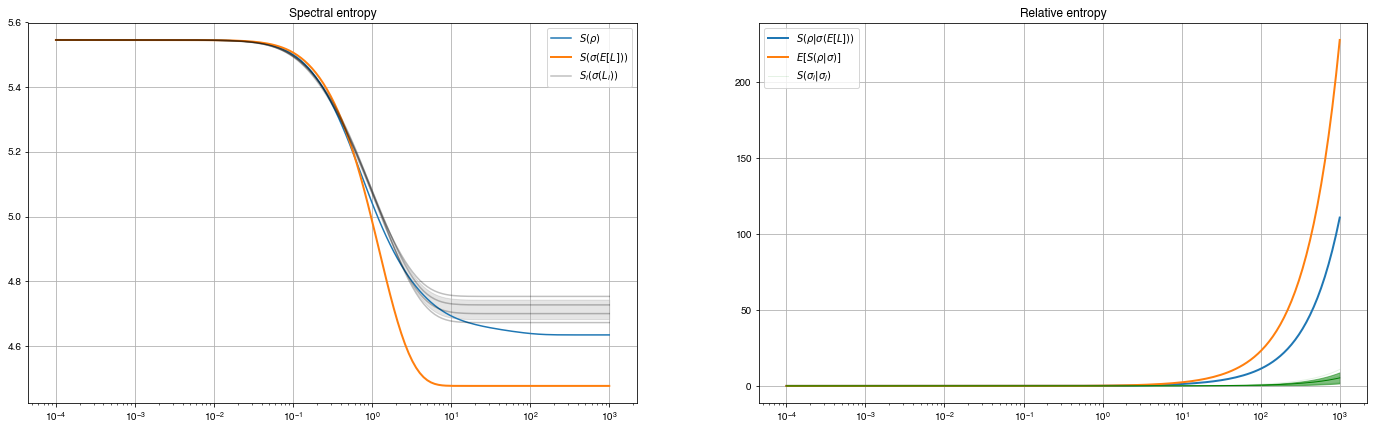

In [9]:
fig, ax = plt.subplots(figsize=(24,7),ncols=2)
ax[0].semilogx(beta_range,S,label='data')
ax[0].semilogx(beta_range,Srandom,label='null',linewidth=2)
ax[0].semilogx(beta_range,Srandombatch,label='null batch',color='k',alpha=1/batch_size)
ax[0].fill_between(beta_range,Srandombatch.mean(1)-Srandombatch.std(1),Srandombatch.mean(1)+Srandombatch.std(1),color='k',alpha=0.1)
ax[0].legend(['$S(\\rho)$','$S(\\sigma(E[L]))$','$S_i(\\sigma(L_i))$'])
ax[0].grid(True)
ax[0].set_title('Spectral entropy')

ax[1].semilogx(beta_range,dklnull,linewidth=2)
ax[1].semilogx(beta_range,dklsamples,linewidth=2)
ax[1].semilogx(beta_range,dklsamplessamples,label='samples vs samples',color='g',alpha=0.1,linewidth=1)
ax[1].semilogx(beta_range,dklsamplessamples.mean(1),color='g',linewidth=1)
ax[1].fill_between(beta_range,dklsamplessamples.mean(1)-dklsamplessamples.std(1),dklsamplessamples.mean(1)+dklsamplessamples.std(1),color='g',alpha=0.5)
ax[1].legend(['$S(\\rho \| \\sigma(E[L]))$','$E[S(\\rho \\| \\sigma)]$','$S(\\sigma_i \| \sigma_j)$'])
ax[1].set_title('Relative entropy')
ax[1].grid(True)
#plt.savefig('/home/carlo/entropies_cwtecm_sample.png')
#plt.savefig('entropies_dkl_638_thresh_02_ubcm.pdf',bbox_inches='tight')
plt.show()

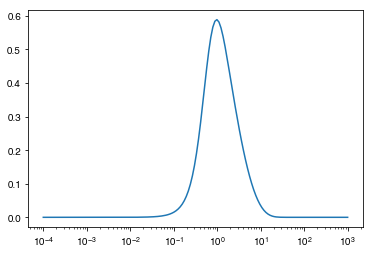

In [26]:
import networkx as nx
G1 = nx.disjoint_union_all([nx.complete_graph(4),nx.complete_graph(6)])
G2 = nx.disjoint_union_all([nx.path_graph(4),nx.path_graph(6)])
A1 = nx.to_numpy_array(G1)
A2 = nx.to_numpy_array(G2)
dkl = nq.relative_entropy(nq.graph_laplacian(A1),nq.graph_laplacian(A2),beta_range)
plt.semilogx(beta_range,dkl)

In [ ]:
allZ=[]
allF=[]
for beta in beta_range:
    Z = np.exp(-beta*np.linalg.eigvalsh(nq.graph_laplacian(M.expected_adjacency(sol['x'])))).sum()
    allZ.append(Z)
    allF.append(-np.log(Z))


In [ ]:
nq.plot_mle(G, np.squeeze(M.sample_adjacency(sol['x'])), np.squeeze(M.sample_adjacency(sol['x'])))
plt.savefig('/home/carlo/cwtecm.png')

In [ ]:
nq.plot_mle(G, (sample_adjacency(M,sol['x'],batch_size=100)[1].mean(0)).astype(float),
                np.mean(sample_adjacency(M,sol['x'],batch_size=100)[0],0))

In [ ]:
_=plt.hist(G[np.nonzero(G)],200,label='data',alpha=0.6,density=True)
_=plt.hist(np.squeeze(M.sample_adjacency(sol['x'])).flatten(),200,label='null',alpha=0.6,density=True)
plt.legend()
plt.ylabel('w')
plt.xlabel('frequency')
plt.savefig('/home/carlo/weights_cwtecm.png')

In [ ]:
ws=np.squeeze(sample_adjacency(M,sol['x'])[0])
ws=ws[np.nonzero(G)]
plt.plot(G[np.nonzero(G)],ws,'.')

In [ ]:
G = np.random.exponential(scale=0.01,size=(256,256))

In [ ]:
ws = M.sample_adjacency(theta=sol['x'])
_=plt.hist(W[np.nonzero(W)],label='data',bins=50,alpha=0.5,density=True)
_=plt.hist(ws.flat[ws.flat>0]+25,label='null',bins=50,alpha=0.5,density=True)
plt.legend()
plt.show()